In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv'
df = pd.read_csv(file_path)

In [3]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','neutral_score','day_of_week',]
df.drop(columns=columns_to_drop, inplace=True)

In [4]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
df['sentiment_c'] = df['Sentiment_Classification'].map(sentiment_mapping)

In [5]:
# Create a new column 'helpful' based on the condition
df['helpful'] = (df['helpful_vote'] > 0).astype(int)


In [6]:
# Define features and target variable
features = ['review_ext', 'sentiment_c','word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
       'image', 'ver_purch', '#nouns','#adj', '#adv', 'subjective_score','FRE','product','price','rating']
target = 'helpful'

In [8]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [9]:
# Scaling features and one-hot encoding categorical features

# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['review_ext', 'sentiment_c','word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
       'image', 'ver_purch', '#nouns','#adj', '#adv', 'subjective_score','FRE']


# Convert 'product' column to categorical type
X_train['product'] = X_train['product'].astype('category')
X_test['product'] = X_test['product'].astype('category')

# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
       ("cat", OneHotEncoder(), ['product']),  # One-hot encode 'product'
       ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
   ])

# Scale features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)



Default Model Evaluation:
Accuracy: 0.8705589499886852
Confusion Matrix:
[[3592  136]
 [ 436  255]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93      3728
         1.0       0.65      0.37      0.47       691

    accuracy                           0.87      4419
   macro avg       0.77      0.67      0.70      4419
weighted avg       0.85      0.87      0.86      4419

Mean Cross-Validated Accuracy: 0.8678703785974037


In [11]:
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.8436297804933243                                     
  1%|          | 1/100 [00:00<00:16,  6.04trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                
  3%|▎         | 3/100 [00:00<00:10,  9.38trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                
  7%|▋         | 7/100 [00:00<00:06, 13.45trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                
SCORE:                                                                            
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 11%|█         | 11/100 [00:00<00:06, 13.23trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 15%|█▌        | 15/100 [00:01<00:05, 15.37trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 19%|█▉        | 19/100 [00:01<00:06, 13.29trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 21%|██        | 21/100 [00:01<00:05, 14.12trial/s, best loss: -0.8436297804933243]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8470242136229916                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 25%|██▌       | 25/100 [00:01<00:05, 13.55trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 29%|██▉       | 29/100 [00:02<00:05, 12.78trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 33%|███▎      | 33/100 [00:02<00:04, 13.50trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 35%|███▌      | 35/100 [00:02<00:05, 11.69trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 39%|███▉      | 39/100 [00:03<00:04, 13.21trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 43%|████▎     | 43/100 [00:03<00:05, 10.60trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 45%|████▌     | 45/100 [00:03<00:04, 11.47trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
 47%|████▋     | 47/100 [00:03<00:05, 10.59trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 51%|█████     | 51/100 [00:04<00:03, 12.49trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 53%|█████▎    | 53/100 [00:04<00:04, 11.18trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 57%|█████▋    | 57/100 [00:04<00:03, 13.03trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 61%|██████    | 61/100 [00:04<00:02, 14.34trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 65%|██████▌   | 65/100 [00:05<00:02, 13.13trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 69%|██████▉   | 69/100 [00:05<00:02, 14.13trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 71%|███████   | 71/100 [00:05<00:02, 12.49trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 75%|███████▌  | 75/100 [00:05<00:01, 13.43trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 77%|███████▋  | 77/100 [00:06<00:01, 13.84trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 81%|████████  | 81/100 [00:06<00:01, 13.00trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 85%|████████▌ | 85/100 [00:06<00:01, 13.86trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8470242136229916                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 87%|████████▋ | 87/100 [00:06<00:01, 11.17trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 91%|█████████ | 91/100 [00:07<00:00, 12.79trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 93%|█████████▎| 93/100 [00:07<00:00, 13.33trial/s, best loss: -0.8470242136229916]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8477031002489251                                                                 
SCORE:                                                                             
0.8474768047069473                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
 97%|█████████▋| 97/100 [00:07<00:00, 10.97trial/s, best loss: -0.8477031002489251]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
SCORE:                                                                             
0.8436297804933243                                                                 
100%|██████████| 100/100 [00:07<00:00, 12.52trial/s, best loss: -0.8477031002489251]


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [12]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8277626938735728, 'gamma': 1.695724253465892, 'max_depth': 18.0, 'min_child_weight': 4.0, 'reg_alpha': 41.0, 'reg_lambda': 0.27292394785298946}


In [13]:
best_hyperparams={'colsample_bytree': 0.6488171696858405, 'gamma': 8.814230692351334, 'max_depth': 18, 'min_child_weight': 8.0, 'reg_alpha': 106.0, 'reg_lambda': 0.9692910923949654}


In [14]:
# Considering imbalanced dataset 
from collections import Counter
sqrt = np.sqrt

# Assuming y_train is your ndarray
counts = Counter(y_train.flatten())

# counts[0] will give you the count of 0s
# counts[1] will give you the count of 1s
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = sqrt(count_of_zeros /count_of_ones)

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)


Class distribution in the training set: Counter({0.0: 14880, 1.0: 2792})
scale_pos_weight: 2.3085737791941603


In [16]:
# Train model with default hyperparameters
xgb_cls_opt = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_opt.fit(X_train, y_train)

# Predictions on test data
y_pred_opt = xgb_cls_opt.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nOptimized Model Evaluation:")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_opt, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Optimized Model Evaluation:
Accuracy: 0.8705589499886852
Confusion Matrix:
[[3592  136]
 [ 436  255]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93      3728
         1.0       0.65      0.37      0.47       691

    accuracy                           0.87      4419
   macro avg       0.77      0.67      0.70      4419
weighted avg       0.85      0.87      0.86      4419

Mean Cross-Validated Accuracy: 0.8390678068534478


In [17]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list (categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_train_scaled_df = pd.DataFrame(X_train, columns=all_feature_names)

## 2. Feature Importance with Shap Values

[13:25:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


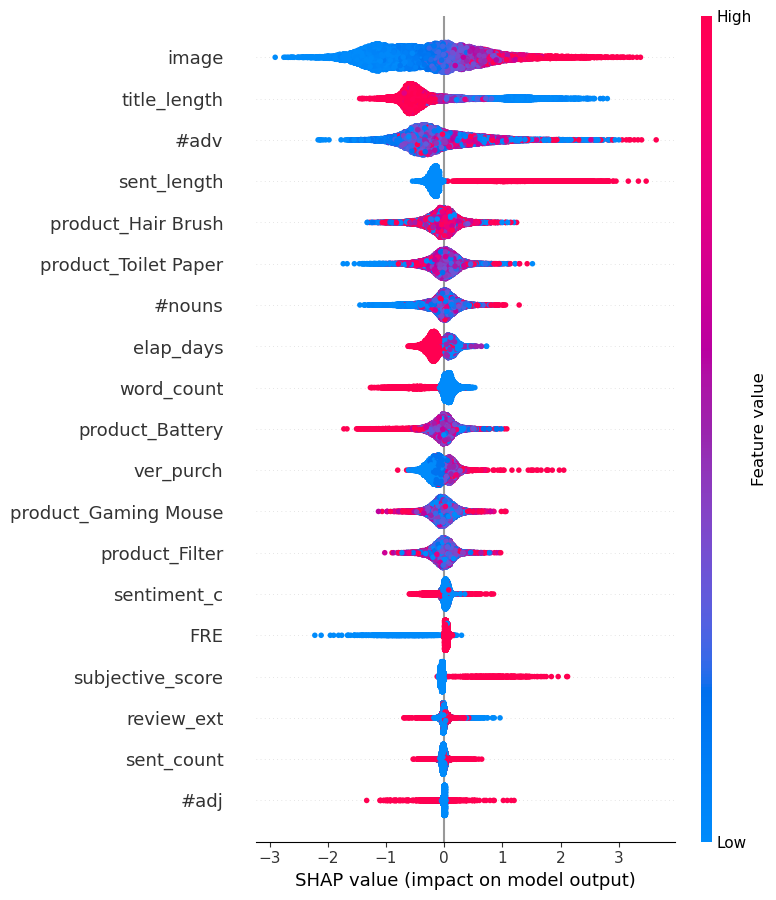

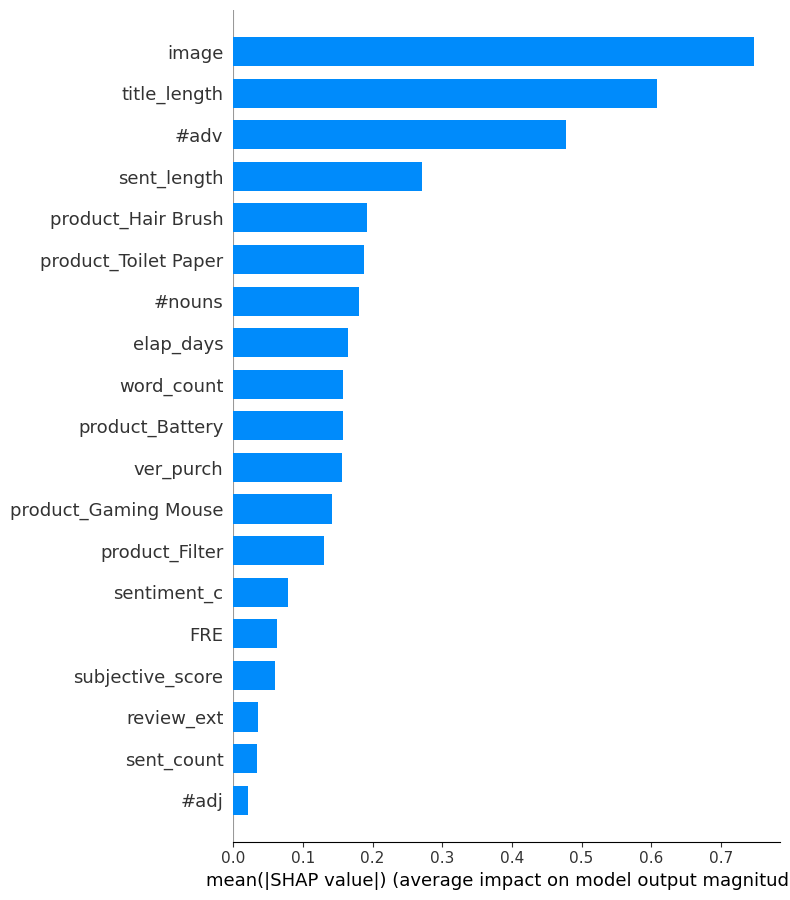

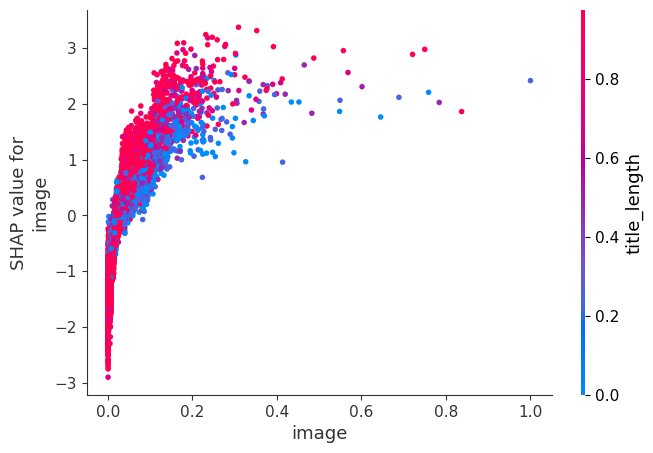

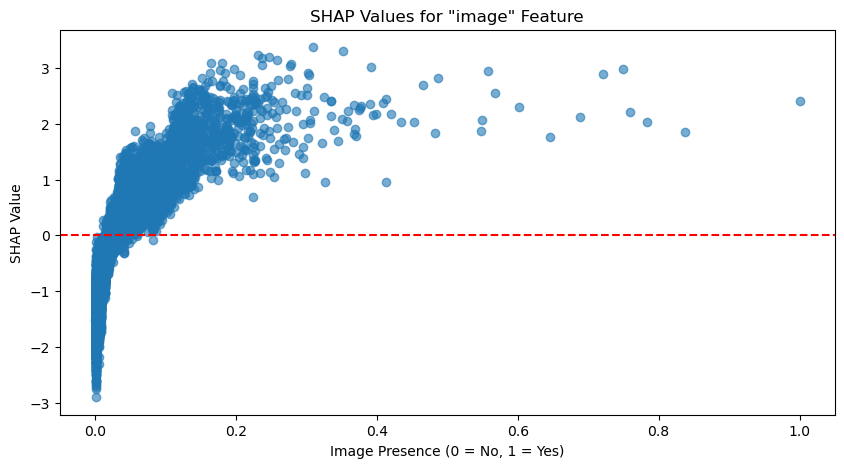

In [18]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_scaled_df)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_scaled_df)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar", show=False)
plt.show()

# Plot specifically for the 'image' feature
shap.dependence_plot('image', shap_values, X_train_scaled_df)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train_scaled_df.columns.get_loc('image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train_scaled_df['image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [18]:
# Create the SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the training set
shap_values_train = explainer.shap_values(X_train_scaled_df)


[08:21:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [19]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values_train).mean(axis=0)


In [20]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train_scaled_df.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

                features  average_shap_value
7                  image            0.695174
5           title_length            0.637951
11                  #adv            0.498556
4            sent_length            0.243437
9                 #nouns            0.204771
17        product_Filter            0.197112
18  product_Gaming Mouse            0.172374
8              ver_purch            0.158747
15                rating            0.156898
14                 price            0.156202
16       product_Battery            0.148479
2             word_count            0.136381
6              elap_days            0.134383
19    product_Hair Brush            0.078572
13                   FRE            0.071958
12      subjective_score            0.062228
1            sentiment_c            0.057009
0             review_ext            0.041117
3             sent_count            0.032487
10                  #adj            0.015754
20  product_Toilet Paper            0.000000
